In [6]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
import datetime

In [3]:
#PARAMETERS
TIMEFRAME = "12h"
PAIR = "BNBUSDT"
DATA_WINDOW_LENGTH = 500
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

In [4]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")

In [5]:
%%capture
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=DATA_WINDOW_LENGTH);

In [84]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [85]:
df = process_klines(klines)

In [86]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(319.17891838336595, 6.7853282851349075)

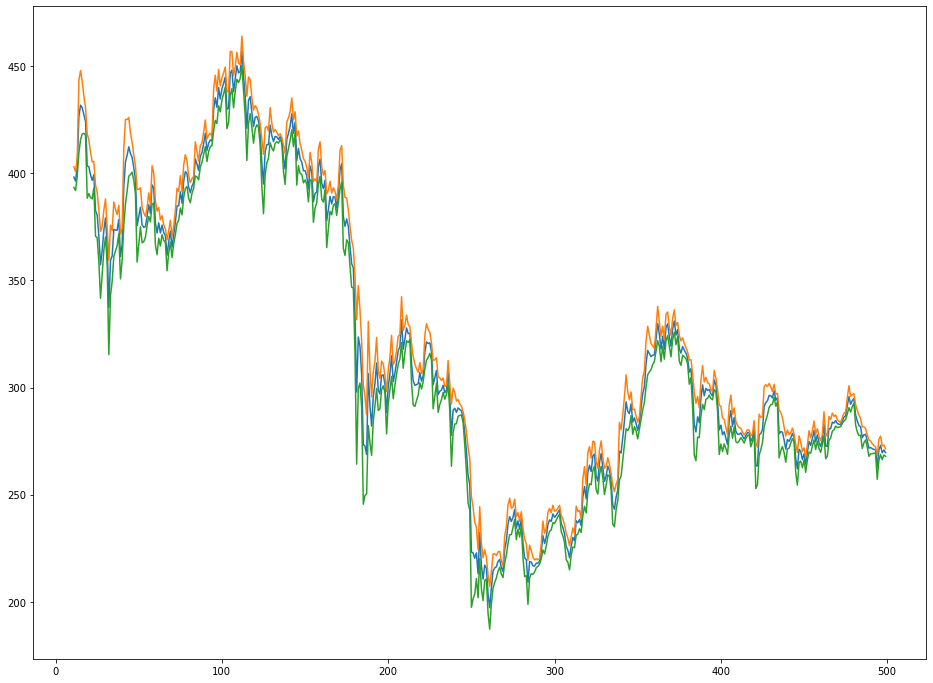

In [87]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [88]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
print(valley_indexes)

[  4  15  30  38  44  58 102 112 117 129 142 159 172 182 188 193 208 223
 242 255 276 303 328 343 372 396 406 432 477]
[  1  12  27  32  39  49  67 103 115 125 138 155 163 181 187 190 199 216
 238 254 261 284 309 336 350 385 404 421 446]


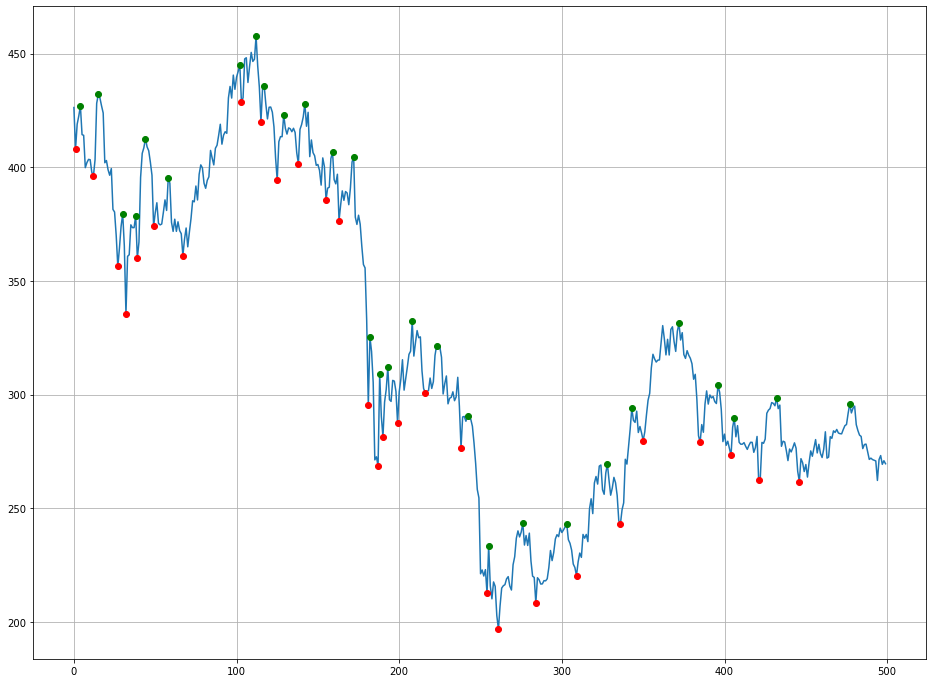

In [89]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [90]:
peak_regions = []
for peak_index in peak_indexes:
    peak_regions.append(peak_index)
    for j in range(min(max(peak_index+1, len(df.close.values) - max(peak_indexes)), 5)):
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    for j in range(min(valley_index+1, len(df.close.values) - max(valley_indexes))):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

43
88


In [91]:
len(peak_regions) - len(peak_indexes)

43

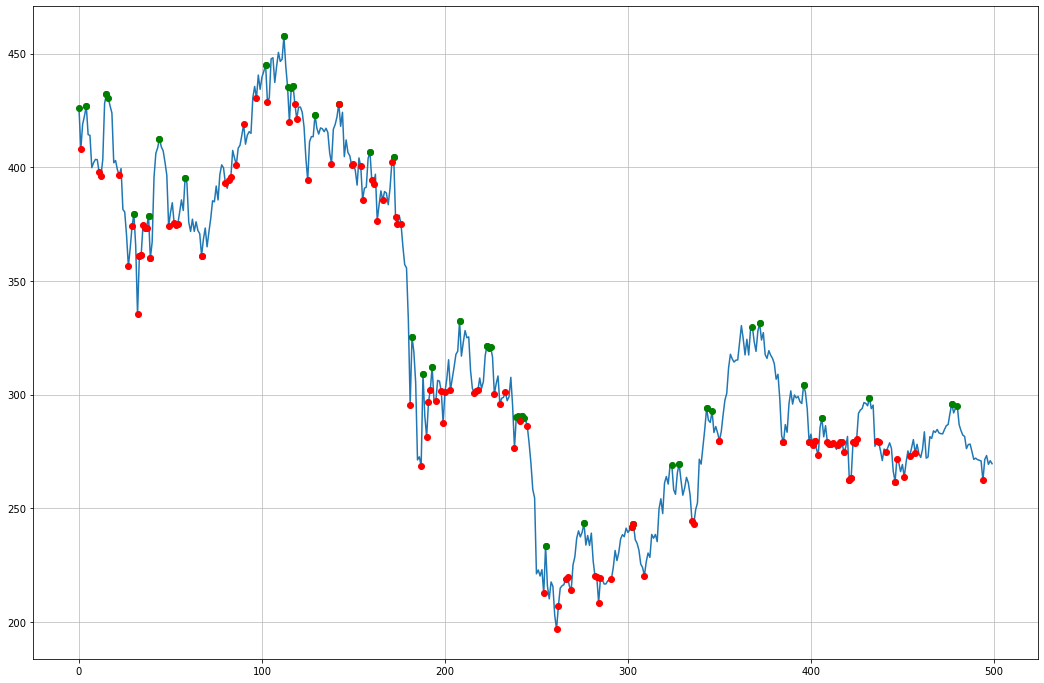

In [92]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


In [93]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
labels = pd.DataFrame(labels, columns=['labels'])
df = pd.concat([df, labels], axis=1)
print(labels[labels!=0].dropna())
    

     labels
0       1.0
1      -1.0
4       1.0
11     -1.0
12     -1.0
..      ...
454    -1.0
457    -1.0
477     1.0
480     1.0
494    -1.0

[146 rows x 1 columns]


In [94]:
df


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2022-02-08 00:00:00,433.14,445.48,420.80,426.27,684172.01,2022-02-08 11:59:59.999,2.959951e+08,383006,322404.81,1.395451e+08,1
1,2022-02-08 12:00:00,426.27,426.29,406.26,407.94,771346.28,2022-02-08 23:59:59.999,3.196802e+08,452780,375909.11,1.557726e+08,-1
2,2022-02-09 00:00:00,407.96,419.73,407.22,418.92,567391.44,2022-02-09 11:59:59.999,2.343230e+08,334605,276495.93,1.141807e+08,0
3,2022-02-09 12:00:00,418.92,427.49,417.55,422.57,596781.94,2022-02-09 23:59:59.999,2.523297e+08,345580,280516.74,1.186349e+08,0
4,2022-02-10 00:00:00,422.56,429.96,414.44,426.89,480447.90,2022-02-10 11:59:59.999,2.027377e+08,299576,232275.43,9.804464e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-10-13 12:00:00,262.23,273.66,255.00,271.40,1119772.74,2022-10-13 23:59:59.999,2.971129e+08,474195,545251.73,1.447347e+08,0
496,2022-10-14 00:00:00,271.39,276.65,271.20,273.16,573314.62,2022-10-14 11:59:59.999,1.572794e+08,253899,280819.52,7.703532e+07,0
497,2022-10-14 12:00:00,273.15,275.35,267.39,269.30,562287.07,2022-10-14 23:59:59.999,1.525116e+08,258969,271909.99,7.376979e+07,0
498,2022-10-15 00:00:00,269.30,271.10,268.60,270.89,238257.63,2022-10-15 11:59:59.999,6.430961e+07,135366,115253.82,3.111167e+07,0


In [109]:
features = df[['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'labels']]
dates = features['open_time'].copy()
# timestamps = pd.to_datetime(features['open_time'], unit='ms')
# print(features['open_time'], type(timestamps), type(features['open_time']))
# features['open_time'] = timestamps
features.rename(columns={"open_time": "timestamp"}, inplace=True)

/tmp/ipykernel_22080/2604319273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns={"open_time": "timestamp"}, inplace=True)


In [110]:
features

,timestamp,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2022-02-08 00:00:00,433.14,445.48,420.80,426.27,684172.01,2.959951e+08,383006,322404.81,1.395451e+08,1
1,2022-02-08 12:00:00,426.27,426.29,406.26,407.94,771346.28,3.196802e+08,452780,375909.11,1.557726e+08,-1
2,2022-02-09 00:00:00,407.96,419.73,407.22,418.92,567391.44,2.343230e+08,334605,276495.93,1.141807e+08,0
3,2022-02-09 12:00:00,418.92,427.49,417.55,422.57,596781.94,2.523297e+08,345580,280516.74,1.186349e+08,0
4,2022-02-10 00:00:00,422.56,429.96,414.44,426.89,480447.90,2.027377e+08,299576,232275.43,9.804464e+07,1
...,...,...,...,...,...,...,...,...,...,...,...
495,2022-10-13 12:00:00,262.23,273.66,255.00,271.40,1119772.74,2.971129e+08,474195,545251.73,1.447347e+08,0
496,2022-10-14 00:00:00,271.39,276.65,271.20,273.16,573314.62,1.572794e+08,253899,280819.52,7.703532e+07,0
497,2022-10-14 12:00:00,273.15,275.35,267.39,269.30,562287.07,1.525116e+08,258969,271909.99,7.376979e+07,0
498,2022-10-15 00:00:00,269.30,271.10,268.60,270.89,238257.63,6.430961e+07,135366,115253.82,3.111167e+07,0


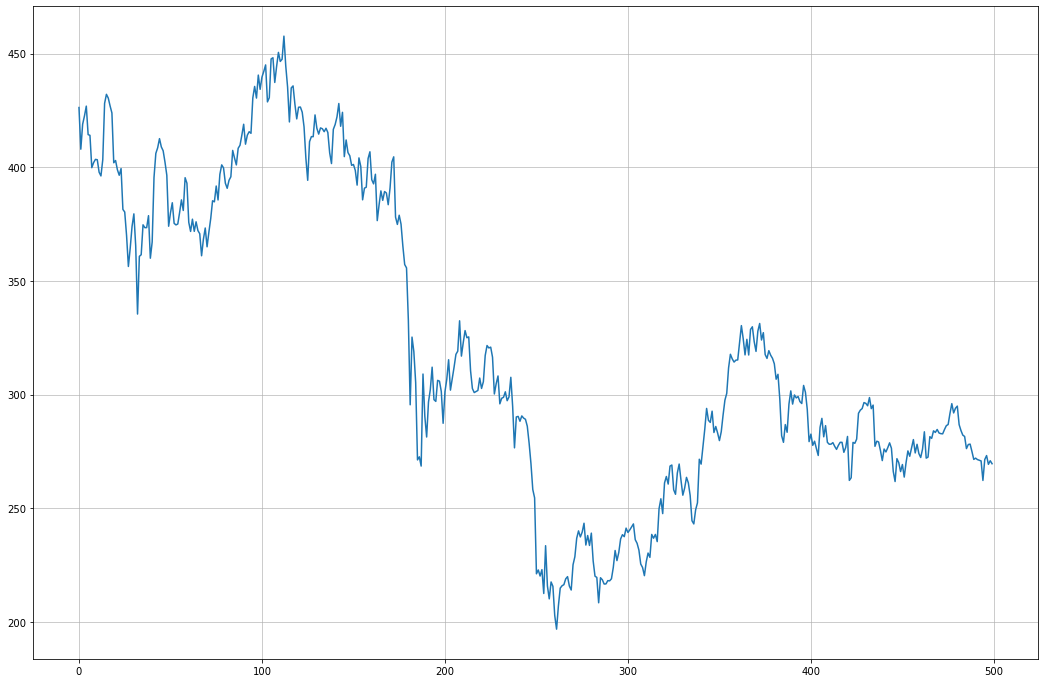

In [104]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)
none = []
for i, l in enumerate(labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = df.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = df.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = df.close.values[none]
ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.5, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [105]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class MarketDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [67]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs